In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
#Configuramos pandas para mostrarnos 20 filas
pd.set_option('display.max_rows', 20)
pd.set_option('display.min_rows', 20)

In [2]:
df=pd.read_csv('C:\\Users\\manuel.decesar\\Desktop\\data_labqt\\WIKI_PRICES_212b326a081eacca455e13140d7bb9db.csv', sep=',')  
df

,ticker,date,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
0,A,1999-11-18,45.50,50.00,40.0000,44.00,44739900.0,0.0,1.0,31.041951,34.112034,27.289627,30.018590,44739900.0
1,A,1999-11-19,42.94,43.00,39.8100,40.38,10897100.0,0.0,1.0,29.295415,29.336350,27.160002,27.548879,10897100.0
2,A,1999-11-22,41.31,44.00,40.0600,44.00,4705200.0,0.0,1.0,28.183363,30.018590,27.330562,30.018590,4705200.0
3,A,1999-11-23,42.50,43.63,40.2500,40.25,4274400.0,0.0,1.0,28.995229,29.766161,27.460188,27.460188,4274400.0
4,A,1999-11-24,40.13,41.94,40.0000,41.06,3464400.0,0.0,1.0,27.378319,28.613174,27.289627,28.012803,3464400.0
5,A,1999-11-26,40.88,41.50,40.7500,41.19,1237100.0,0.0,1.0,27.889999,28.312988,27.801308,28.101494,1237100.0
6,A,1999-11-29,41.00,42.44,40.5600,42.13,2914700.0,0.0,1.0,27.971868,28.954295,27.671682,28.742800,2914700.0
7,A,1999-11-30,42.00,42.94,40.9400,42.19,3083000.0,0.0,1.0,28.654109,29.295415,27.930934,28.783735,3083000.0
8,A,1999-12-01,42.19,43.44,41.8800,42.94,2115400.0,0.0,1.0,28.783735,29.636535,28.572240,29.295415,2115400.0
9,A,1999-12-02,43.75,45.00,43.1900,44.13,2195900.0,0.0,1.0,29.848030,30.700831,29.465975,30.107281,2195900.0


(6.5969999999999995, 8.247]    320
(8.247, 8.558]                 320
(8.558, 8.788]                 320
(8.788, 8.97]                  320
(8.97, 9.131]                  320
(9.131, 9.299]                 319
(9.299, 9.499]                 320
(9.499, 9.738]                 320
(9.738, 10.084]                320
(10.084, 11.844]               320
Name: volume, dtype: int64


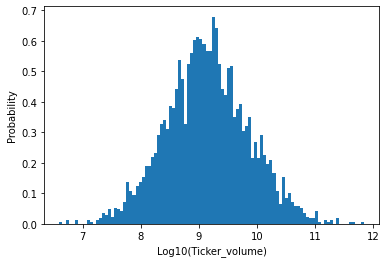

In [3]:
#Análisis volumen por ticker
%matplotlib inline
df_ticker_volume=np.log10(df.groupby(['ticker'])['volume'].sum())
plt.hist(df_ticker_volume, density=True, bins=100)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Log10(Ticker_volume)');
#percentiles
print(pd.qcut(df_ticker_volume,10).value_counts().sort_index())

In [4]:
#Filtrar tickers sin suficiente volumen
#df=df[df['ticker'].isin(df_ticker_volume[df_ticker_volume>8.211].index)]
#df

In [5]:
#Filtrar registros sin volumen
df=df[df['volume']>=1]
df

,ticker,date,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
0,A,1999-11-18,45.50,50.00,40.0000,44.00,44739900.0,0.0,1.0,31.041951,34.112034,27.289627,30.018590,44739900.0
1,A,1999-11-19,42.94,43.00,39.8100,40.38,10897100.0,0.0,1.0,29.295415,29.336350,27.160002,27.548879,10897100.0
2,A,1999-11-22,41.31,44.00,40.0600,44.00,4705200.0,0.0,1.0,28.183363,30.018590,27.330562,30.018590,4705200.0
3,A,1999-11-23,42.50,43.63,40.2500,40.25,4274400.0,0.0,1.0,28.995229,29.766161,27.460188,27.460188,4274400.0
4,A,1999-11-24,40.13,41.94,40.0000,41.06,3464400.0,0.0,1.0,27.378319,28.613174,27.289627,28.012803,3464400.0
5,A,1999-11-26,40.88,41.50,40.7500,41.19,1237100.0,0.0,1.0,27.889999,28.312988,27.801308,28.101494,1237100.0
6,A,1999-11-29,41.00,42.44,40.5600,42.13,2914700.0,0.0,1.0,27.971868,28.954295,27.671682,28.742800,2914700.0
7,A,1999-11-30,42.00,42.94,40.9400,42.19,3083000.0,0.0,1.0,28.654109,29.295415,27.930934,28.783735,3083000.0
8,A,1999-12-01,42.19,43.44,41.8800,42.94,2115400.0,0.0,1.0,28.783735,29.636535,28.572240,29.295415,2115400.0
9,A,1999-12-02,43.75,45.00,43.1900,44.13,2195900.0,0.0,1.0,29.848030,30.700831,29.465975,30.107281,2195900.0


In [6]:
#Filtrar muestra para desarrollo
df=df.sort_values(by=['date'], ascending=False)[4000000:5000000]
df=df.sort_values(by=['ticker','date'])
df

,ticker,date,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
2858,A,2011-03-31,44.92,45.02,44.4600,44.78,2194900.0,0.0,1.0,30.646252,30.714476,30.332421,30.550738,2194900.0
2859,A,2011-04-01,44.88,45.48,44.7840,45.14,2212300.0,0.0,1.0,30.618962,31.028306,30.553467,30.796345,2212300.0
2860,A,2011-04-04,45.07,45.41,44.3600,44.83,2133900.0,0.0,1.0,30.748588,30.980550,30.264197,30.584850,2133900.0
2861,A,2011-04-05,44.75,45.50,44.6100,45.34,3136800.0,0.0,1.0,30.530271,31.041951,30.434757,30.932793,3136800.0
2862,A,2011-04-06,45.51,45.70,44.7200,45.29,2351900.0,0.0,1.0,31.048774,31.178399,30.509803,30.898681,2351900.0
2863,A,2011-04-07,45.23,45.44,44.2600,44.87,2102400.0,0.0,1.0,30.857746,31.001017,30.195973,30.612140,2102400.0
2864,A,2011-04-08,45.19,45.67,44.7700,44.89,2001500.0,0.0,1.0,30.830457,31.157932,30.543916,30.625784,2001500.0
2865,A,2011-04-11,44.80,45.36,44.6500,44.99,1578800.0,0.0,1.0,30.564383,30.946438,30.462047,30.694008,1578800.0
2866,A,2011-04-12,44.74,45.40,44.2800,44.94,2771600.0,0.0,1.0,30.523448,30.973727,30.209618,30.659896,2771600.0
2867,A,2011-04-13,45.21,46.73,45.2000,46.59,5098300.0,0.0,1.0,30.844101,31.881107,30.837279,31.785594,5098300.0


In [7]:
#Filtramos columnas relevantes para el modelo
df=df.reset_index()[['ticker','date','adj_close','adj_volume']]

In [8]:
#fijamos los tipos de datos
df['date']=pd.to_datetime(df['date'])
df

,ticker,date,adj_close,adj_volume
0,A,2011-03-31,30.550738,2194900.0
1,A,2011-04-01,30.796345,2212300.0
2,A,2011-04-04,30.584850,2133900.0
3,A,2011-04-05,30.932793,3136800.0
4,A,2011-04-06,30.898681,2351900.0
5,A,2011-04-07,30.612140,2102400.0
6,A,2011-04-08,30.625784,2001500.0
7,A,2011-04-11,30.694008,1578800.0
8,A,2011-04-12,30.659896,2771600.0
9,A,2011-04-13,31.785594,5098300.0


In [9]:
#Establecemos índice (ticker y fecha)
df=df.set_index(['ticker','date'])
df

adj_close  adj_volume
ticker date                             
A      2011-03-31  30.550738   2194900.0
       2011-04-01  30.796345   2212300.0
       2011-04-04  30.584850   2133900.0
       2011-04-05  30.932793   3136800.0
       2011-04-06  30.898681   2351900.0
       2011-04-07  30.612140   2102400.0
       2011-04-08  30.625784   2001500.0
       2011-04-11  30.694008   1578800.0
       2011-04-12  30.659896   2771600.0
       2011-04-13  31.785594   5098300.0
...                      ...         ...
ZUMZ   2012-08-17  35.800000    353500.0
       2012-08-20  34.520000    324800.0
       2012-08-21  34.860000    330100.0
       2012-08-22  34.230000    446900.0
       2012-08-23  33.440000    285800.0
       2012-08-24  31.510000   1097200.0
       2012-08-27  31.340000    635000.0
       2012-08-28  31.830000    716700.0
       2012-08-29  31.570000   1133600.0
       2012-08-30  32.220000   1632900.0

[1000000 rows x 2 columns]

In [10]:
#tickers posibles
print(np.unique(df.index.get_level_values(0)))
#fechas posibles
print(np.unique(df.index.get_level_values(1)))

['A' 'AAL' 'AAN' ... 'ZNGA' 'ZQK' 'ZUMZ']
['2011-03-30T00:00:00.000000000' '2011-03-31T00:00:00.000000000'
 '2011-04-01T00:00:00.000000000' '2011-04-04T00:00:00.000000000'
 '2011-04-05T00:00:00.000000000' '2011-04-06T00:00:00.000000000'
 '2011-04-07T00:00:00.000000000' '2011-04-08T00:00:00.000000000'
 '2011-04-11T00:00:00.000000000' '2011-04-12T00:00:00.000000000'
 '2011-04-13T00:00:00.000000000' '2011-04-14T00:00:00.000000000'
 '2011-04-15T00:00:00.000000000' '2011-04-18T00:00:00.000000000'
 '2011-04-19T00:00:00.000000000' '2011-04-20T00:00:00.000000000'
 '2011-04-21T00:00:00.000000000' '2011-04-25T00:00:00.000000000'
 '2011-04-26T00:00:00.000000000' '2011-04-27T00:00:00.000000000'
 '2011-04-28T00:00:00.000000000' '2011-04-29T00:00:00.000000000'
 '2011-05-02T00:00:00.000000000' '2011-05-03T00:00:00.000000000'
 '2011-05-04T00:00:00.000000000' '2011-05-05T00:00:00.000000000'
 '2011-05-06T00:00:00.000000000' '2011-05-09T00:00:00.000000000'
 '2011-05-10T00:00:00.000000000' '2011-05-11T00:

In [69]:
#Calculamos el retorno respecto al día anterior: incremento relativo del ticker respecto el día anterior
df['return_d']=df.groupby(level='ticker')['adj_close'].pct_change()
df

adj_close  adj_volume  return_d
ticker date                                       
A      2011-03-31  30.550738   2194900.0       NaN
       2011-04-01  30.796345   2212300.0  0.008039
       2011-04-04  30.584850   2133900.0 -0.006868
       2011-04-05  30.932793   3136800.0  0.011376
       2011-04-06  30.898681   2351900.0 -0.001103
       2011-04-07  30.612140   2102400.0 -0.009274
       2011-04-08  30.625784   2001500.0  0.000446
       2011-04-11  30.694008   1578800.0  0.002228
       2011-04-12  30.659896   2771600.0 -0.001111
       2011-04-13  31.785594   5098300.0  0.036716
...                      ...         ...       ...
ZUMZ   2012-08-17  35.800000    353500.0  0.018782
       2012-08-20  34.520000    324800.0 -0.035754
       2012-08-21  34.860000    330100.0  0.009849
       2012-08-22  34.230000    446900.0 -0.018072
       2012-08-23  33.440000    285800.0 -0.023079
       2012-08-24  31.510000   1097200.0 -0.057715
       2012-08-27  31.340000    635000.0 -0.005395
       2012-08-28  31.830000    716700.0  0.015635
       2012-08-29  31.570000   1133600.0 -0.008168
       2012-08-30  32.220000   1632900.0  0.020589

[1000000 rows x 3 columns]

In [11]:
#Calculamos el retorno respecto a la semana anterior: incremento relativo del ticker respecto a la semana anterior
df['return_w']=df.groupby(level='ticker')['adj_close'].pct_change(periods=5)
df

adj_close  adj_volume  return_w
ticker date                                       
A      2011-03-31  30.550738   2194900.0       NaN
       2011-04-01  30.796345   2212300.0       NaN
       2011-04-04  30.584850   2133900.0       NaN
       2011-04-05  30.932793   3136800.0       NaN
       2011-04-06  30.898681   2351900.0       NaN
       2011-04-07  30.612140   2102400.0  0.002010
       2011-04-08  30.625784   2001500.0 -0.005538
       2011-04-11  30.694008   1578800.0  0.003569
       2011-04-12  30.659896   2771600.0 -0.008822
       2011-04-13  31.785594   5098300.0  0.028704
...                      ...         ...       ...
ZUMZ   2012-08-17  35.800000    353500.0  0.051086
       2012-08-20  34.520000    324800.0  0.019492
       2012-08-21  34.860000    330100.0  0.023188
       2012-08-22  34.230000    446900.0 -0.002622
       2012-08-23  33.440000    285800.0 -0.048378
       2012-08-24  31.510000   1097200.0 -0.119832
       2012-08-27  31.340000    635000.0 -0.092121
       2012-08-28  31.830000    716700.0 -0.086919
       2012-08-29  31.570000   1133600.0 -0.077710
       2012-08-30  32.220000   1632900.0 -0.036483

[1000000 rows x 3 columns]

In [71]:
#Calculamos el retorno respecto al año anterior: incremento relativo del ticker respecto el año anterior
df['return_y']=df.groupby(level='ticker')['adj_close'].pct_change(periods=252)
df

adj_close  adj_volume  return_d  return_w  return_y
ticker date                                                           
A      2011-03-31  30.550738   2194900.0       NaN       NaN       NaN
       2011-04-01  30.796345   2212300.0  0.008039       NaN       NaN
       2011-04-04  30.584850   2133900.0 -0.006868       NaN       NaN
       2011-04-05  30.932793   3136800.0  0.011376       NaN       NaN
       2011-04-06  30.898681   2351900.0 -0.001103       NaN       NaN
       2011-04-07  30.612140   2102400.0 -0.009274  0.002010       NaN
       2011-04-08  30.625784   2001500.0  0.000446 -0.005538       NaN
       2011-04-11  30.694008   1578800.0  0.002228  0.003569       NaN
       2011-04-12  30.659896   2771600.0 -0.001111 -0.008822       NaN
       2011-04-13  31.785594   5098300.0  0.036716  0.028704       NaN
...                      ...         ...       ...       ...       ...
ZUMZ   2012-08-17  35.800000    353500.0  0.018782  0.051086  1.105882
       2012-08-20  34.520000    324800.0 -0.035754  0.019492  1.002320
       2012-08-21  34.860000    330100.0  0.009849  0.023188  1.078712
       2012-08-22  34.230000    446900.0 -0.018072 -0.002622  0.810153
       2012-08-23  33.440000    285800.0 -0.023079 -0.048378  0.781566
       2012-08-24  31.510000   1097200.0 -0.057715 -0.119832  0.717166
       2012-08-27  31.340000    635000.0 -0.005395 -0.092121  0.681330
       2012-08-28  31.830000    716700.0  0.015635 -0.086919  0.632308
       2012-08-29  31.570000   1133600.0 -0.008168 -0.077710  0.637448
       2012-08-30  32.220000   1632900.0  0.020589 -0.036483  0.742564

[1000000 rows x 5 columns]

In [12]:
#Cierre ajustado promediado semanal
df['adj_close_w']=df.groupby(level='ticker')['adj_close'].apply(lambda grp: grp.rolling(5).mean())
df.loc['AMZN']

,adj_close,adj_volume,return_w,adj_close_w
date,,,,
2011-03-30,179.420,6859300.0,NaN,NaN
2011-03-31,180.130,4826500.0,NaN,NaN
2011-04-01,180.130,5684100.0,NaN,NaN
2011-04-04,182.940,4186400.0,NaN,NaN
2011-04-05,185.290,5569200.0,NaN,181.5820
2011-04-06,182.760,5430700.0,0.018616,182.2500
2011-04-07,184.910,4564000.0,0.026536,183.2060
2011-04-08,184.710,3726400.0,0.025426,184.1220
2011-04-11,184.040,3297100.0,0.006013,184.3420


In [18]:
#Cierre ajustado promediado ponderado por volumen
df['adj_close_ww']=df.reset_index('ticker').groupby('ticker').apply(lambda grp: (grp['adj_close']*grp['adj_volume']).rolling(5).sum()/grp['adj_volume'].rolling(5).sum())
df.loc['AMZN']

,adj_close,adj_volume,return_w,adj_close_w,adj_close_ww
date,,,,,
2011-03-30,179.420,6859300.0,NaN,NaN,NaN
2011-03-31,180.130,4826500.0,NaN,NaN,NaN
2011-04-01,180.130,5684100.0,NaN,NaN,NaN
2011-04-04,182.940,4186400.0,NaN,NaN,NaN
2011-04-05,185.290,5569200.0,NaN,181.5820,181.443552
2011-04-06,182.760,5430700.0,0.018616,182.2500,182.261915
2011-04-07,184.910,4564000.0,0.026536,183.2060,183.141650
2011-04-08,184.710,3726400.0,0.025426,184.1220,184.119761
2011-04-11,184.040,3297100.0,0.006013,184.3420,184.326778


In [19]:
#Retorno respecto al cierre ajustado promediado ponderado
df['return_ww']=df.apply(lambda x: (x['adj_close']-x['adj_close_ww'])/x['adj_close_ww'], axis=1)
df

adj_close  adj_volume  return_w  adj_close_w  adj_close_ww  \
ticker date                                                                     
A      2011-03-31  30.550738   2194900.0       NaN          NaN           NaN   
       2011-04-01  30.796345   2212300.0       NaN          NaN           NaN   
       2011-04-04  30.584850   2133900.0       NaN          NaN           NaN   
       2011-04-05  30.932793   3136800.0       NaN          NaN           NaN   
       2011-04-06  30.898681   2351900.0       NaN    30.752681     30.769603   
       2011-04-07  30.612140   2102400.0  0.002010    30.764961     30.782113   
       2011-04-08  30.625784   2001500.0 -0.005538    30.730849     30.752746   
       2011-04-11  30.694008   1578800.0  0.003569    30.752681     30.776515   
       2011-04-12  30.659896   2771600.0 -0.008822    30.698102     30.701241   
       2011-04-13  31.785594   5098300.0  0.028704    30.875484     31.074896   
...                      ...         ...       ...          ...           ...   
ZUMZ   2012-08-17  35.800000    353500.0  0.051086    34.638000     34.669428   
       2012-08-20  34.520000    324800.0  0.019492    34.770000     34.762632   
       2012-08-21  34.860000    330100.0  0.023188    34.928000     34.961161   
       2012-08-22  34.230000    446900.0 -0.002622    34.910000     34.858316   
       2012-08-23  33.440000    285800.0 -0.048378    34.570000     34.592626   
       2012-08-24  31.510000   1097200.0 -0.119832    33.712000     33.059680   
       2012-08-27  31.340000    635000.0 -0.092121    33.076000     32.499283   
       2012-08-28  31.830000    716700.0 -0.086919    32.470000     32.103587   
       2012-08-29  31.570000   1133600.0 -0.077710    31.938000     31.701558   
       2012-08-30  32.220000   1632900.0 -0.036483    31.694000     31.768613   

                   return_ww  
ticker date                   
A      2011-03-31        NaN  
       2011-04-01        NaN  
       2011-04-04        NaN  
       2011-04-05        NaN  
       2011-04-06   0.004195  
       2011-04-07  -0.005522  
       2011-04-08  -0.004128  
       2011-04-11  -0.002681  
       2011-04-12  -0.001347  
       2011-04-13   0.022870  
...                      ...  
ZUMZ   2012-08-17   0.032610  
       2012-08-20  -0.006980  
       2012-08-21  -0.002894  
       2012-08-22  -0.018025  
       2012-08-23  -0.033320  
       2012-08-24  -0.046875  
       2012-08-27  -0.035671  
       2012-08-28  -0.008522  
       2012-08-29  -0.004150  
       2012-08-30   0.014209  

[1000000 rows x 6 columns]

In [54]:
#Volatilidad semanal
df['volatility_w']=df.reset_index('ticker').groupby('ticker').apply(lambda grp: grp['adj_close'].rolling(5).std())
df

adj_close  adj_volume  return_w  adj_close_w  adj_close_ww  \
ticker date                                                                     
A      2011-03-31  30.550738   2194900.0       NaN          NaN           NaN   
       2011-04-01  30.796345   2212300.0       NaN          NaN           NaN   
       2011-04-04  30.584850   2133900.0       NaN          NaN           NaN   
       2011-04-05  30.932793   3136800.0       NaN          NaN           NaN   
       2011-04-06  30.898681   2351900.0       NaN    30.752681     30.769603   
       2011-04-07  30.612140   2102400.0  0.002010    30.764961     30.782113   
       2011-04-08  30.625784   2001500.0 -0.005538    30.730849     30.752746   
       2011-04-11  30.694008   1578800.0  0.003569    30.752681     30.776515   
       2011-04-12  30.659896   2771600.0 -0.008822    30.698102     30.701241   
       2011-04-13  31.785594   5098300.0  0.028704    30.875484     31.074896   
...                      ...         ...       ...          ...           ...   
ZUMZ   2012-08-17  35.800000    353500.0  0.051086    34.638000     34.669428   
       2012-08-20  34.520000    324800.0  0.019492    34.770000     34.762632   
       2012-08-21  34.860000    330100.0  0.023188    34.928000     34.961161   
       2012-08-22  34.230000    446900.0 -0.002622    34.910000     34.858316   
       2012-08-23  33.440000    285800.0 -0.048378    34.570000     34.592626   
       2012-08-24  31.510000   1097200.0 -0.119832    33.712000     33.059680   
       2012-08-27  31.340000    635000.0 -0.092121    33.076000     32.499283   
       2012-08-28  31.830000    716700.0 -0.086919    32.470000     32.103587   
       2012-08-29  31.570000   1133600.0 -0.077710    31.938000     31.701558   
       2012-08-30  32.220000   1632900.0 -0.036483    31.694000     31.768613   

                   return_ww  return_f_d  volatility_w  zscore_w  
ticker date                                                       
A      2011-03-31        NaN    0.008039           NaN -0.022581  
       2011-04-01        NaN   -0.006868           NaN -0.022518  
       2011-04-04        NaN    0.011376           NaN -0.022701  
       2011-04-05        NaN   -0.001103           NaN -0.022598  
       2011-04-06   0.004195   -0.009274      0.176501 -0.022505  
       2011-04-07  -0.005522    0.000446      0.160334 -0.022610  
       2011-04-08  -0.004128    0.002228      0.169849 -0.022611  
       2011-04-11  -0.002681   -0.001111      0.152523 -0.022335  
       2011-04-12  -0.001347    0.036716      0.116541 -0.022080  
       2011-04-13   0.022870    0.000859      0.509758 -0.021707  
...                      ...         ...           ...       ...  
ZUMZ   2012-08-17   0.032610   -0.035754      0.811061 -0.018161  
       2012-08-20  -0.006980    0.009849      0.698713 -0.018644  
       2012-08-21  -0.002894   -0.018072      0.580103 -0.018475  
       2012-08-22  -0.018025   -0.023079      0.604566 -0.018676  
       2012-08-23  -0.033320   -0.057715      0.864870 -0.018837  
       2012-08-24  -0.046875   -0.005395      1.338084 -0.019670  
       2012-08-27  -0.035671    0.015635      1.590041 -0.019719  
       2012-08-28  -0.008522   -0.008168      1.289050 -0.019592  
       2012-08-29  -0.004150    0.020589      0.857887 -0.019676  
       2012-08-30   0.014209         NaN      0.342681  0.057873  

[1000000 rows x 9 columns]

In [62]:
#Zscore
df['zscore']=df.groupby('date')['adj_close'].transform(lambda grp: (grp - grp.mean())/ grp.std())
df

adj_close  adj_volume  return_w  adj_close_w  adj_close_ww  \
ticker date                                                                     
A      2011-03-31  30.550738   2194900.0       NaN          NaN           NaN   
       2011-04-01  30.796345   2212300.0       NaN          NaN           NaN   
       2011-04-04  30.584850   2133900.0       NaN          NaN           NaN   
       2011-04-05  30.932793   3136800.0       NaN          NaN           NaN   
       2011-04-06  30.898681   2351900.0       NaN    30.752681     30.769603   
       2011-04-07  30.612140   2102400.0  0.002010    30.764961     30.782113   
       2011-04-08  30.625784   2001500.0 -0.005538    30.730849     30.752746   
       2011-04-11  30.694008   1578800.0  0.003569    30.752681     30.776515   
       2011-04-12  30.659896   2771600.0 -0.008822    30.698102     30.701241   
       2011-04-13  31.785594   5098300.0  0.028704    30.875484     31.074896   
...                      ...         ...       ...          ...           ...   
ZUMZ   2012-08-17  35.800000    353500.0  0.051086    34.638000     34.669428   
       2012-08-20  34.520000    324800.0  0.019492    34.770000     34.762632   
       2012-08-21  34.860000    330100.0  0.023188    34.928000     34.961161   
       2012-08-22  34.230000    446900.0 -0.002622    34.910000     34.858316   
       2012-08-23  33.440000    285800.0 -0.048378    34.570000     34.592626   
       2012-08-24  31.510000   1097200.0 -0.119832    33.712000     33.059680   
       2012-08-27  31.340000    635000.0 -0.092121    33.076000     32.499283   
       2012-08-28  31.830000    716700.0 -0.086919    32.470000     32.103587   
       2012-08-29  31.570000   1133600.0 -0.077710    31.938000     31.701558   
       2012-08-30  32.220000   1632900.0 -0.036483    31.694000     31.768613   

                   return_ww  return_f_d  volatility_w  zscore_w    zscore  
ticker date                                                                 
A      2011-03-31        NaN    0.008039           NaN       NaN -0.022581  
       2011-04-01        NaN   -0.006868           NaN       NaN -0.022518  
       2011-04-04        NaN    0.011376           NaN       NaN -0.022701  
       2011-04-05        NaN   -0.001103           NaN       NaN -0.022598  
       2011-04-06   0.004195   -0.009274      0.176501       NaN -0.022505  
       2011-04-07  -0.005522    0.000446      0.160334       NaN -0.022610  
       2011-04-08  -0.004128    0.002228      0.169849       NaN -0.022611  
       2011-04-11  -0.002681   -0.001111      0.152523       NaN -0.022335  
       2011-04-12  -0.001347    0.036716      0.116541       NaN -0.022080  
       2011-04-13   0.022870    0.000859      0.509758       NaN -0.021707  
...                      ...         ...           ...       ...       ...  
ZUMZ   2012-08-17   0.032610   -0.035754      0.811061  0.555280 -0.018161  
       2012-08-20  -0.006980    0.009849      0.698713  0.509924 -0.018644  
       2012-08-21  -0.002894   -0.018072      0.580103  0.525475 -0.018475  
       2012-08-22  -0.018025   -0.023079      0.604566  0.514193 -0.018676  
       2012-08-23  -0.033320   -0.057715      0.864870  0.502388 -0.018837  
       2012-08-24  -0.046875   -0.005395      1.338084  0.441749 -0.019670  
       2012-08-27  -0.035671    0.015635      1.590041  0.440351 -0.019719  
       2012-08-28  -0.008522   -0.008168      1.289050  0.452158 -0.019592  
       2012-08-29  -0.004150    0.020589      0.857887  0.432226 -0.019676  
       2012-08-30   0.014209         NaN      0.342681  1.754538  0.057873  

[1000000 rows x 10 columns]

In [63]:
#Calculamos el retorno al día siguiente: incremento relativo del ticker en el día siguiente (target)
df['return_f_d']=df.groupby(level='ticker')['adj_close'].pct_change().shift(periods=-1)
df

adj_close  adj_volume  return_w  adj_close_w  adj_close_ww  \
ticker date                                                                     
A      2011-03-31  30.550738   2194900.0       NaN          NaN           NaN   
       2011-04-01  30.796345   2212300.0       NaN          NaN           NaN   
       2011-04-04  30.584850   2133900.0       NaN          NaN           NaN   
       2011-04-05  30.932793   3136800.0       NaN          NaN           NaN   
       2011-04-06  30.898681   2351900.0       NaN    30.752681     30.769603   
       2011-04-07  30.612140   2102400.0  0.002010    30.764961     30.782113   
       2011-04-08  30.625784   2001500.0 -0.005538    30.730849     30.752746   
       2011-04-11  30.694008   1578800.0  0.003569    30.752681     30.776515   
       2011-04-12  30.659896   2771600.0 -0.008822    30.698102     30.701241   
       2011-04-13  31.785594   5098300.0  0.028704    30.875484     31.074896   
...                      ...         ...       ...          ...           ...   
ZUMZ   2012-08-17  35.800000    353500.0  0.051086    34.638000     34.669428   
       2012-08-20  34.520000    324800.0  0.019492    34.770000     34.762632   
       2012-08-21  34.860000    330100.0  0.023188    34.928000     34.961161   
       2012-08-22  34.230000    446900.0 -0.002622    34.910000     34.858316   
       2012-08-23  33.440000    285800.0 -0.048378    34.570000     34.592626   
       2012-08-24  31.510000   1097200.0 -0.119832    33.712000     33.059680   
       2012-08-27  31.340000    635000.0 -0.092121    33.076000     32.499283   
       2012-08-28  31.830000    716700.0 -0.086919    32.470000     32.103587   
       2012-08-29  31.570000   1133600.0 -0.077710    31.938000     31.701558   
       2012-08-30  32.220000   1632900.0 -0.036483    31.694000     31.768613   

                   return_ww  return_f_d  volatility_w  zscore_w    zscore  
ticker date                                                                 
A      2011-03-31        NaN    0.008039           NaN       NaN -0.022581  
       2011-04-01        NaN   -0.006868           NaN       NaN -0.022518  
       2011-04-04        NaN    0.011376           NaN       NaN -0.022701  
       2011-04-05        NaN   -0.001103           NaN       NaN -0.022598  
       2011-04-06   0.004195   -0.009274      0.176501       NaN -0.022505  
       2011-04-07  -0.005522    0.000446      0.160334       NaN -0.022610  
       2011-04-08  -0.004128    0.002228      0.169849       NaN -0.022611  
       2011-04-11  -0.002681   -0.001111      0.152523       NaN -0.022335  
       2011-04-12  -0.001347    0.036716      0.116541       NaN -0.022080  
       2011-04-13   0.022870    0.000859      0.509758       NaN -0.021707  
...                      ...         ...           ...       ...       ...  
ZUMZ   2012-08-17   0.032610   -0.035754      0.811061  0.555280 -0.018161  
       2012-08-20  -0.006980    0.009849      0.698713  0.509924 -0.018644  
       2012-08-21  -0.002894   -0.018072      0.580103  0.525475 -0.018475  
       2012-08-22  -0.018025   -0.023079      0.604566  0.514193 -0.018676  
       2012-08-23  -0.033320   -0.057715      0.864870  0.502388 -0.018837  
       2012-08-24  -0.046875   -0.005395      1.338084  0.441749 -0.019670  
       2012-08-27  -0.035671    0.015635      1.590041  0.440351 -0.019719  
       2012-08-28  -0.008522   -0.008168      1.289050  0.452158 -0.019592  
       2012-08-29  -0.004150    0.020589      0.857887  0.432226 -0.019676  
       2012-08-30   0.014209         NaN      0.342681  1.754538  0.057873  

[1000000 rows x 10 columns]

Retornos diarios


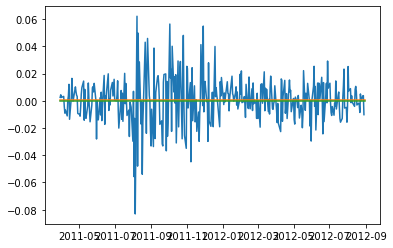

Retornos diarios acumulados sin reinvertir


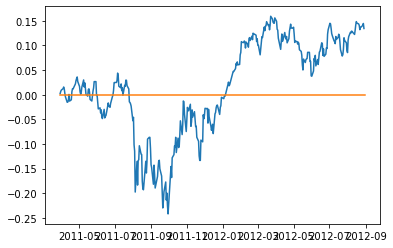

Retornos diarios acumulados reinvirtiendo


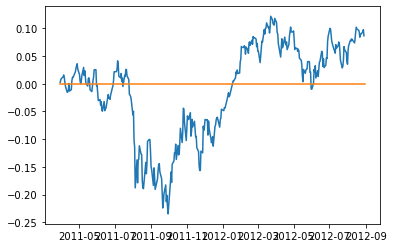

In [24]:
#Retornos diarios estrategia básica (estrategia de repartir a partes iguales entre todos los tickers diariamente)
s=df.groupby(level='date')['return_f_d'].mean()
print('Retornos diarios')
plt.plot(s)
plt.plot(s.index,[s.mean()]*len(s.index))
plt.plot(s.index,[0]*len(s.index))
plt.show() 
#Retornos diarios acumulados hasta la fecha sin reinvertir los retornos diarios
print('Retornos diarios acumulados sin reinvertir')
cs=s.cumsum()
plt.plot(cs)
plt.plot(cs.index,[0]*len(cs.index))
plt.show() 
#Retornos diarios acumulados hasta la fecha reinvirtiendo los retornos diarios
print('Retornos diarios acumulados reinvirtiendo')
rcs=(s+1).cumprod()
plt.plot(rcs-1)
plt.plot(rcs.index,[0]*len(rcs.index))
plt.show()

Siguiente:

ver código de Manu 0013_init_example (sharepoint lab)

feature zscore

segmentation model (proportional segmentation)

tree model (like in 0013_init_example)

more comlex model 